## Import 

In [2]:
# Neural Network
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import keras
import tensorflow as tf

# For measuring the inference time.
import time
import random

# Computer Vision
import cv2

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Images

In [3]:
# Alters pictures
image_gen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    preprocessing_function=None,
    data_format=None)

In [4]:
# Loading Images
image_gen = image_gen.flow_from_directory(
    "Data-Images",
    target_size=(300, 300),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=2591,
    shuffle=True,
    seed=123,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    interpolation='nearest')

Found 2453 images belonging to 3 classes.


In [5]:
# Image classes
image_gen.class_indices

{'Assault Rifle': 0, 'Handgun': 1, 'No Firearm': 2}

In [6]:
# Image shape
image_gen.image_shape

(300, 300, 3)

## Separating To Images and Labels

In [7]:
images, labels = next(image_gen)

In [8]:
images.shape

(2453, 300, 300, 3)

In [9]:
labels.shape

(2453, 3)

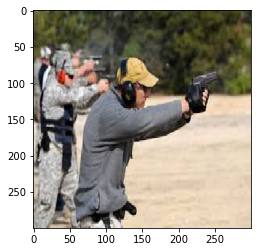

In [10]:
plt.imshow(images[23])

In [11]:
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

# Selective Search

In [12]:
# Setting a max amount of region proposals used when running selective search
max_proposals = 2_000
max_proposals_infer = 200  # Search for (1) gathering training data and (2) performing inference

In [13]:
# Define the maximum number of positive and negative images to be
# Denerated from each image
max_positive = 30
max_negative = 10

In [19]:
# initialize the input dimensions to the network
input_dimensions = (300, 300)  # 300 by 300 because that's what the CNN Model was tested on
# define the path to the output model
model_path = "model_3.hdf5"
cnn_model = keras.models.load_model(model_path)  # Loading CNN model from keras

# define the minimum probability required for a positive prediction
# (used to filter out false-positive predictions)
MIN_PROBA = 0.99

# IoU (Intersection Over Union)

In [20]:
def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

# Selective Search

In [21]:
# initialize OpenCV's selective search implementation and set the
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [22]:
# Input image in selective search
image = images[5]
ss.setBaseImage(image)

# Choosing which selective search
ss.switchToSelectiveSearchQuality()

In [23]:
# run selective search on the input image
start = time.time()
rects = ss.process()  # Run Selective Search
end = time.time()

# show how along selective search took to run along with the total
# number of returned region proposals
print("[INFO] selective search took {:.4f} seconds".format(end - start))
print("[INFO] {} total region proposals".format(len(rects)))

[INFO] selective search took 1.8000 seconds
[INFO] 1769 total region proposals


In [24]:
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects[:max_proposals_infer]:
    # extract the region from the input image, convert it from BGR to
    # RGB channel ordering, and then resize it to the required input
    # dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = cv2.resize(roi, input_dimensions,
        interpolation=cv2.INTER_CUBIC)
    # further preprocess the ROI
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
    # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))

In [ ]:
# convert the proposals and bounding boxes into NumPy arrays
proposals = np.array(proposals, dtype="float32")
boxes = np.array(boxes, dtype="int32")
print(f"[INFO] proposal shape: {proposals.shape}")

# classify each of the proposal ROIs using fine-tuned model
print("[INFO] classifying proposals...")
proba = cnn_model.predict(proposals)

[INFO] proposal shape: (200, 300, 300, 3)
[INFO] classifying proposals...


# View Results

In [18]:
# loop over the region proposals in chunks (so we can better
# visualize them)
# for i in range(0, len(rects), 100):
#     # clone the original image so we can draw on it
#     output = image.copy()
#     # loop over the current subset of region proposals
#     for (x, y, w, h) in rects[i:i + 100]:
#         # draw the region proposal bounding box on the image
#         color = [random.randint(0, 255) for j in range(0, 3)]
#         cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)
#     # show the output image
#     cv2.imshow("Output", output)
#     key = cv2.waitKey(0) & 0xFF
#     # if the `q` key was pressed, break from the loop
#     if key == ord("q"):
#         break